# Example of a quadcopter UAV

The modelling here is heavily inspired from http://www.gipsa-lab.grenoble-inp.fr/~nicolas.marchand/teaching/Nonlinear_PSPI.pdf

<img src="quadcopter.png" alt="drawing" width="200"/>

The motor 1 is at the front, the motor 2 is at the right, etc.

$ s_i $ is the rotation speed for the motor i

$ F_i $ is the force deployed by the motor i and its propeller

$ l $ is the length of one arm, from the COM to the motor axis

Roll torque is generated with a dissymmetry between left and right forces: $ \Gamma_r=l.(F_4−F_2) $

Pitch torque is generated with a dissymmetry between front and rear forces: $ \Gamma_p=l.(F_1−F_3) $

Yaw torque is generated with a dissymmetry between front/rear and left/right torques: $ \Gamma_y=\Gamma_1+\Gamma_3−\Gamma_2−\Gamma_4 $

For one motor, we use an **approximation** of a first order system:
    
$ \dot{s} = -\frac{k_m^2}{J_r.R}.s - \frac{1}{J_r}.\tau_{load} + \frac{k_m}{J_r.R}.sat_{\bar{U}}(U) $

where :

* $ s $ is the rotation speed
* $ U $ is the voltage applied to the motor (command variable)
* $ \tau_{load} $ is the motor load : $ \tau_{load} = k_{gb}.\kappa.s.|s| $

In summary :

* $ F = b.(s_1^2 +s_2^2+s_3^2+s_4^2)$
* $ \Gamma_r = l.b.(s_4^2-s_2^2) $
* $ \Gamma_p = l.b.(s_1^2 - s_3^2) $
* $ \Gamma_y = \kappa.(s_1^2+s_3^2-s_2^2-s_4^2) $

## Quadcopter definition
We start with the 4 motors

### The motors

In [1]:
from blocksim.quadcopter.Motor import Motor

mot0 = Motor(prefix="mot", num=0)
mot1 = Motor(prefix="mot", num=1)
mot2 = Motor(prefix="mot", num=2)
mot3 = Motor(prefix="mot", num=3)

[INFO] - Registered blocksim.loggers.CSVLogger
[INFO] - Registered blocksim.loggers.PickleLogger
[INFO] - Registered blocksim.loggers.PsqlLogger
[INFO] - Registered blocksim.loggers.XlsLogger


We use a AntiWindupPIDController to control the motors' speed

In [2]:
from blocksim.control.Controller import AntiWindupPIDController

tau = 50e-3
Ks = 0.0

l_ctl_mot = []
for imot in range(4):
    ctl_mot = AntiWindupPIDController(
        f"ctlmot{imot}", snames=["u"], shape_estimation=(2,)
    )
    ctl_mot.D = 0.0
    ctl_mot.I = mot0.km / tau
    ctl_mot.P = ctl_mot.I * mot0.Jr * mot0.R / mot0.km**2
    ctl_mot.Ks = Ks
    ctl_mot.Umin = -mot0.Umax
    ctl_mot.Umax = mot0.Umax
    l_ctl_mot.append(ctl_mot)

In [3]:
import numpy as np

from blocksim.Simulation import Simulation
from blocksim.graphics import plotGraph

sim = Simulation(l_ctl_mot)
sim.addComputer(mot0, mot1, mot2, mot3)

# We could have made the connections in the previous loop
sim.connect("ctlmot0.command", "mot0.command")
sim.connect("ctlmot1.command", "mot1.command")
sim.connect("ctlmot2.command", "mot2.command")
sim.connect("ctlmot3.command", "mot3.command")
sim.connect("mot0.vel", "ctlmot0.estimation")
sim.connect("mot1.vel", "ctlmot1.estimation")
sim.connect("mot2.vel", "ctlmot2.estimation")
sim.connect("mot3.vel", "ctlmot3.estimation")

/home/blaudiy/.venv/menv/lib/python3.8/site-packages/networkx/drawing/layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


<AxesSubplot:>

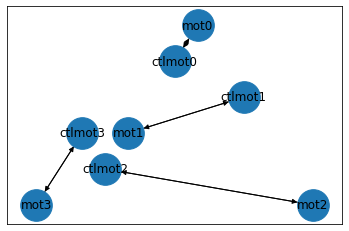

In [4]:
g = sim.computeGraph()
plotGraph(g)

### Motor simulation

In [5]:
from blocksim.control.SetPoint import Step

stp = Step(name="stp", snames=["c"], cons=np.array([1]))

sim.addComputer(stp)
sim.connect("stp.setpoint", "ctlmot0.setpoint")

tps = np.arange(0, 1, 0.01)
sim.simulate(tps, progress_bar=False, error_on_unconnected=False)

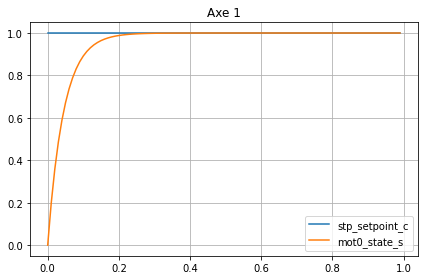

In [6]:
from blocksim.graphics import plotVerif

log = sim.getLogger()
_ = plotVerif(
    log,
    "Figure 1",
    [{"var": "stp_setpoint_c"}, {"var": "mot0_state_s"}],
)

In [7]:
sim.removeComputer(stp)

### Quadcopter

In [8]:
from blocksim.quadcopter.Quadri import Quadri

sys = Quadri(name="sys", mot=mot0)
x0 = sys.getInitialStateForOutput("state")
x0[:6] = np.array([0, 0, 0, 2.349619, -2.409138, 4.907362])
w0 = np.array([2, -1, 3]) / 2
x0[10:13] = w0
sys.setInitialStateForOutput(x0, "state")

sim.addComputer(sys)

We group the state of all motors to feed it to the Quadri's command

In [9]:
from blocksim.control.Route import Group

grp_inp = {}
grp_inp["in0"] = (1,)
grp_inp["in1"] = (1,)
grp_inp["in2"] = (1,)
grp_inp["in3"] = (1,)
grp = Group(
    "grp",
    inputs=grp_inp,
    snames=["gs0", "gs1", "gs2", "gs3"],
)

sim.addComputer(grp)

sim.connect("mot0.state", "grp.in0")
sim.connect("mot1.state", "grp.in1")
sim.connect("mot2.state", "grp.in2")
sim.connect("mot3.state", "grp.in3")
sim.connect("grp.grouped", "sys.command")

## Controlling the quadcopter
### Attitude controller
Then we need an attitude controller

In [10]:
from blocksim.quadcopter.AttPilot import AttPilot

ctlatt = AttPilot("ctlatt", sys)

sim.addComputer(ctlatt)

sim.connect("sys.state", "ctlatt.estimation")
sim.connect("sys.euler", "ctlatt.euler")

The attitude command is a 4 scalar vector, that needs to be split among the 4 motors

In [11]:
from blocksim.control.Route import Split

spt_otp = {}
spt_otp["u0"] = (0,)
spt_otp["u1"] = (1,)
spt_otp["u2"] = (2,)
spt_otp["u3"] = (3,)
spt = Split(
    name="spt",
    signal_shape=(7,),
    outputs=spt_otp,
)

sim.addComputer(spt)

sim.connect("ctlatt.command", "spt.signal")
sim.connect("spt.u0", "ctlmot0.setpoint")
sim.connect("spt.u1", "ctlmot1.setpoint")
sim.connect("spt.u2", "ctlmot2.setpoint")
sim.connect("spt.u3", "ctlmot3.setpoint")

### VTOLcontroller
Then we need hte position / velocity controller
The VTOL controller commands an attitude, that has to be realized by the attitude controller

In [12]:
from blocksim.quadcopter.VTOLPilot import VTOLPilot

ctlvtol = VTOLPilot(name="ctlvtol", grav=9.81)
ctlvtol.matQ = np.eye(6)
ctlvtol.matR = np.eye(3) * 5
ctlvtol.matA = np.zeros((6, 6))
ctlvtol.matA[0:3, 3:6] = np.eye(3)
ctlvtol.matB = np.zeros((6, 3))
ctlvtol.matB[3:6, :] = np.eye(3)
ctlvtol.matC = np.zeros((3, 6))
ctlvtol.matC[:, 0:3] = np.eye(3)
ctlvtol.matD = np.zeros((3, 3))
ctlvtol.computeGain()

sim.addComputer(ctlvtol)

sim.connect("ctlvtol.att", "ctlatt.setpoint")

The VTOL controller needs in input the positoin and velocity of the quadcopter. We will use the real state vetcor (in the real life, we only have IMU measurement, precessed by a Kalman filter. But here, we simplify !).
But the Quadri instance has a state vector with attitude and attitude rate data. So we split the state to keep only positoin and velocity.

In [13]:
wspt_otp = {}
wspt_otp["pv"] = list(range(6))
wtolspt = Split(
    name="wtolspt",
    signal_shape=(13,),
    outputs=wspt_otp,
)

sim.addComputer(wtolspt)

sim.connect("sys.state", "wtolspt.signal")
sim.connect("wtolspt.pv", "ctlvtol.estimation")

### User input
The user gives a constant input of 0: we want the quadcopter to remain steady.

In [14]:
stp = Step(
    "stp",
    cons=np.array([0, 0, 0, 0]),
    snames=["x_cons", "y_cons", "z_cons", "psi_cons"],
)

sim.addComputer(stp)

sim.connect("stp.setpoint", "ctlvtol.setpoint")

## Simulation and plotting

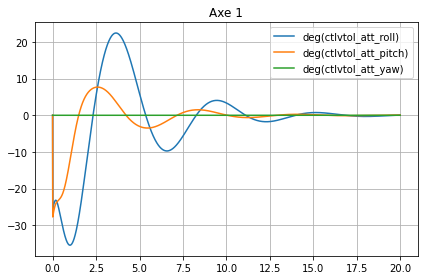

In [15]:
tps = np.arange(0, 20, 0.01)
sim.simulate(tps, progress_bar=False)
log = sim.getLogger()

_ = plotVerif(
    log,
    "Figure 3",
    [
        {"var": "deg(ctlvtol_att_roll)"},
        {"var": "deg(ctlvtol_att_pitch)"},
        {"var": "deg(ctlvtol_att_yaw)"},
    ],
    [
        {"var": "sys_state_pz"},
    ],
)